# Finalist Analysis: Effect of Reaching the World Cup Final

This notebook analyzes the economic effect of **reaching the World Cup Final** (winner OR runner-up).

**Treatment**: Finalist = rank1 (winner) OR rank2 (runner-up)

**Methods**:
1. Event Study Design with two-way fixed effects
2. Synthetic Difference-in-Differences (SDID)

**Comparison**: Results compared against winner-only analysis from Mello (2024)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Data

In [2]:
# Load the event study sample
df = pd.read_csv('../data/mello_paper_replication/paper_replication_event_study_sample.csv')

# Define column names
gdp_col = 'gross_domestic_product_chain_linked_volume_rebased_us_dollars_ppp_converted'
gdp_yoy_col = f'{gdp_col}_yoy_pct'
gdp_yoy_log_col = f'{gdp_col}_yoy_log_4q'

# Create time index
df['tq'] = df['year'] * 4 + df['qtr']
df = df.sort_values(['country', 'tq'])

print(f"Loaded {len(df):,} rows, {df['country'].nunique()} countries")
print(f"Time range: {df['quarter'].min()} to {df['quarter'].max()}")
print(f"\nColumns with rank info: rank1 (winner), rank2 (runner-up)")

Loaded 8,737 rows, 48 countries
Time range: 1961-Q1 to 2021-Q4

Columns with rank info: rank1 (winner), rank2 (runner-up)


## 2. Define Finalists (Winners + Runners-up)

In [3]:
# World Cup Finals 1966-2018 (within paper timeframe)
# Format: (year, winner_ISO3, runner_up_ISO3)
wc_finals = [
    (1966, 'GBR', 'DEU'),  # England vs West Germany
    (1970, 'BRA', 'ITA'),  # Brazil vs Italy
    (1974, 'DEU', 'NLD'),  # West Germany vs Netherlands
    (1978, 'ARG', 'NLD'),  # Argentina vs Netherlands
    (1982, 'ITA', 'DEU'),  # Italy vs West Germany
    (1986, 'ARG', 'DEU'),  # Argentina vs West Germany
    (1990, 'DEU', 'ARG'),  # West Germany vs Argentina
    (1994, 'BRA', 'ITA'),  # Brazil vs Italy
    (1998, 'FRA', 'BRA'),  # France vs Brazil
    (2002, 'BRA', 'DEU'),  # Brazil vs Germany
    (2006, 'ITA', 'FRA'),  # Italy vs France
    (2010, 'ESP', 'NLD'),  # Spain vs Netherlands
    (2014, 'DEU', 'ARG'),  # Germany vs Argentina
    (2018, 'FRA', 'HRV'),  # France vs Croatia
]

# Create finalist events list (country, year, role)
finalist_events = []
for year, winner, runner_up in wc_finals:
    finalist_events.append((winner, year, 'winner'))
    finalist_events.append((runner_up, year, 'runner-up'))

finalist_df = pd.DataFrame(finalist_events, columns=['country', 'year', 'role'])
finalist_df['tq_event'] = finalist_df['year'] * 4 + 2  # Q2 is the World Cup quarter

print("World Cup Finalists (1966-2018):")
print(finalist_df.to_string(index=False))
print(f"\nTotal finalist events: {len(finalist_df)}")
print(f"Unique finalist countries: {finalist_df['country'].nunique()}")

World Cup Finalists (1966-2018):
country  year      role  tq_event
    GBR  1966    winner      7866
    DEU  1966 runner-up      7866
    BRA  1970    winner      7882
    ITA  1970 runner-up      7882
    DEU  1974    winner      7898
    NLD  1974 runner-up      7898
    ARG  1978    winner      7914
    NLD  1978 runner-up      7914
    ITA  1982    winner      7930
    DEU  1982 runner-up      7930
    ARG  1986    winner      7946
    DEU  1986 runner-up      7946
    DEU  1990    winner      7962
    ARG  1990 runner-up      7962
    BRA  1994    winner      7978
    ITA  1994 runner-up      7978
    FRA  1998    winner      7994
    BRA  1998 runner-up      7994
    BRA  2002    winner      8010
    DEU  2002 runner-up      8010
    ITA  2006    winner      8026
    FRA  2006 runner-up      8026
    ESP  2010    winner      8042
    NLD  2010 runner-up      8042
    DEU  2014    winner      8058
    ARG  2014 runner-up      8058
    FRA  2018    winner      8074
    HRV  2018 r

In [4]:
# Get unique finalist countries (ever reached a final)
finalist_countries = finalist_df['country'].unique().tolist()
print(f"Finalist countries: {sorted(finalist_countries)}")

# Compare with winner-only countries
winner_countries = ['BRA', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA']  # From original analysis
runner_up_only = [c for c in finalist_countries if c not in winner_countries]
print(f"\nWinner countries (original): {winner_countries}")
print(f"Runner-up only countries (new): {runner_up_only}")

# Create finalist indicator in the main dataframe
df['finalist'] = df['country'].isin(finalist_countries).astype(int)
df['winner'] = df['country'].isin(winner_countries).astype(int)

print(f"\nFinalist observations: {df['finalist'].sum():,}")
print(f"Winner observations: {df['winner'].sum():,}")
print(f"Control observations: {(1 - df['finalist']).sum():,}")

Finalist countries: ['ARG', 'BRA', 'DEU', 'ESP', 'FRA', 'GBR', 'HRV', 'ITA', 'NLD']

Winner countries (original): ['BRA', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA']
Runner-up only countries (new): ['NLD', 'ARG', 'HRV']

Finalist observations: 1,775
Winner observations: 1,315
Control observations: 6,962


---
# PART A: EVENT STUDY ANALYSIS
---

## 3. Construct Event Time for Finalists

In [5]:
# Assign relative time to nearest finalist event for each country
def assign_rel_time_finalist(ctry, tq_series):
    """Compute relative time to nearest finalist event for a country."""
    events = finalist_df[finalist_df['country'] == ctry]['tq_event'].values
    if len(events) > 0:
        return tq_series.apply(lambda t: min(t - events, key=abs))
    else:
        return pd.Series(0, index=tq_series.index)  # Controls: doesn't matter

# Apply by country
df['rel_time'] = df.groupby('country').apply(
    lambda g: assign_rel_time_finalist(g.name, g['tq'])
).reset_index(level=0, drop=True)

df['rel_time_bin'] = df['rel_time'].clip(-16, 16).astype(int)

print("Event time distribution (finalists only):")
print(df[df['finalist']==1]['rel_time_bin'].value_counts().sort_index().head(10))

Event time distribution (finalists only):
rel_time_bin
-16    590
-15     18
-14     18
-13     18
-12     18
-11     18
-10     18
-9      18
-8      18
-7      22
Name: count, dtype: int64


## 4. Event Study Regression

In [6]:
# Prepare regression data
df['ln_gdp'] = np.log(df[gdp_col])
df['ln_gdp_l4'] = df.groupby('country')['ln_gdp'].shift(4)
df['dy_gdp_pp'] = df[gdp_yoy_log_col]
df['host'] = df['host'].fillna(0).astype(int)

# Create regression sample
reg_vars = ['dy_gdp_pp', 'ln_gdp_l4', 'host', 'rel_time_bin', 'finalist', 'country', 'tq']
df_reg = df[reg_vars].dropna().copy()

# Create FINALIST_l dummies (l = -16 to +16, excluding l=0 as reference)
for l in range(-16, 17):
    if l != 0:
        col_name = f'FINAL_m{abs(l)}' if l < 0 else f'FINAL_p{l}'
        df_reg[col_name] = ((df_reg['rel_time_bin'] == l) & (df_reg['finalist'] == 1)).astype(int)

print(f"Regression sample: {len(df_reg):,} obs, {df_reg['country'].nunique()} countries")

Regression sample: 8,545 obs, 48 countries


In [7]:
# Try to use pyfixest, fallback to manual estimation if not available
try:
    import pyfixest as pf
    USE_PYFIXEST = True
    print("Using pyfixest for event study regression")
except ImportError:
    USE_PYFIXEST = False
    print("pyfixest not available, using manual OLS with fixed effects")

pyfixest not available, using manual OLS with fixed effects


In [8]:
if USE_PYFIXEST:
    # Build formula for event study
    win_vars_neg = [f'FINAL_m{abs(l)}' for l in range(-16, 0)]
    win_vars_pos = [f'FINAL_p{l}' for l in range(1, 17)]
    win_vars = win_vars_neg + win_vars_pos
    
    formula = f"dy_gdp_pp ~ ln_gdp_l4 + host + {' + '.join(win_vars)} | country + tq"
    
    # Estimate with clustered SEs
    model = pf.feols(formula, data=df_reg, vcov={'CRV1': 'country'})
    
    # Extract coefficients
    coef_df = pd.DataFrame({
        'variable': model.coef().index,
        'coef': model.coef().values,
        'se': model.se().values
    })
    
    # Parse event time from variable names
    def parse_event_time(var):
        if var.startswith('FINAL_m'):
            return -int(var.replace('FINAL_m', ''))
        elif var.startswith('FINAL_p'):
            return int(var.replace('FINAL_p', ''))
        return None
    
    coef_df['l'] = coef_df['variable'].apply(parse_event_time)
    coef_df = coef_df[coef_df['l'].notna()].copy()
    coef_df['l'] = coef_df['l'].astype(int)
    coef_df = coef_df.sort_values('l')
    
    # Add reference period (l=0)
    ref_row = pd.DataFrame({'variable': ['FINAL_0'], 'coef': [0], 'se': [0], 'l': [0]})
    coef_df = pd.concat([coef_df, ref_row]).sort_values('l')
    
    print("\nEvent Study Coefficients (Finalist):")
    print(coef_df[['l', 'coef', 'se']].to_string(index=False))
else:
    # Manual OLS with demeaned data (within transformation)
    print("Manual FE estimation...")
    
    # Demean by country and time
    for col in ['dy_gdp_pp', 'ln_gdp_l4', 'host'] + [c for c in df_reg.columns if c.startswith('FINAL_')]:
        if col in df_reg.columns:
            df_reg[f'{col}_dm'] = df_reg.groupby('country')[col].transform(lambda x: x - x.mean())
            df_reg[f'{col}_dm'] = df_reg.groupby('tq')[f'{col}_dm'].transform(lambda x: x - x.mean())
    
    # Get variable names
    y_col_dm = 'dy_gdp_pp_dm'
    x_cols_dm = ['ln_gdp_l4_dm', 'host_dm'] + [f'{c}_dm' for c in df_reg.columns if c.startswith('FINAL_') and '_dm' not in c]
    x_cols_dm = [c for c in x_cols_dm if c in df_reg.columns]
    
    # OLS
    from numpy.linalg import lstsq
    y = df_reg[y_col_dm].values
    X = df_reg[x_cols_dm].values
    
    coefs, residuals, rank, s = lstsq(X, y, rcond=None)
    
    # Simple standard errors (not clustered)
    n, k = X.shape
    resid = y - X @ coefs
    sigma2 = np.sum(resid**2) / (n - k)
    var_coef = sigma2 * np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(var_coef))
    
    coef_df = pd.DataFrame({'variable': x_cols_dm, 'coef': coefs, 'se': se})
    
    def parse_event_time(var):
        var = var.replace('_dm', '')
        if 'FINAL_m' in var:
            return -int(var.split('FINAL_m')[1])
        elif 'FINAL_p' in var:
            return int(var.split('FINAL_p')[1])
        return None
    
    coef_df['l'] = coef_df['variable'].apply(parse_event_time)
    coef_df = coef_df[coef_df['l'].notna()].copy()
    coef_df['l'] = coef_df['l'].astype(int)
    
    # Add reference period
    ref_row = pd.DataFrame({'variable': ['FINAL_0'], 'coef': [0], 'se': [0], 'l': [0]})
    coef_df = pd.concat([coef_df, ref_row]).sort_values('l')
    
    print("\nEvent Study Coefficients (Finalist):")
    print(coef_df[['l', 'coef', 'se']].head(15).to_string(index=False))

# Store finalist event study results for comparison
finalist_es_results = coef_df[['l', 'coef', 'se']].copy()
finalist_es_results.columns = ['l', 'finalist_coef', 'finalist_se']

Manual FE estimation...



Event Study Coefficients (Finalist):
  l    coef     se
-16  1.2377 0.6226
-15  1.3810 0.8986
-14  1.0883 0.8986
-13  1.1018 0.8985
-12  1.0044 0.8985
-11  0.9942 0.8985
-10  1.0629 0.8985
 -9  1.0099 0.8984
 -8  0.4728 0.8984
 -7  0.4497 0.8523
 -6  0.4389 0.8523
 -5  0.8202 0.8522
 -4  0.7260 0.8522
 -3  0.2003 0.8522
 -2 -0.1331 0.8522


## 5. Event Study Plot

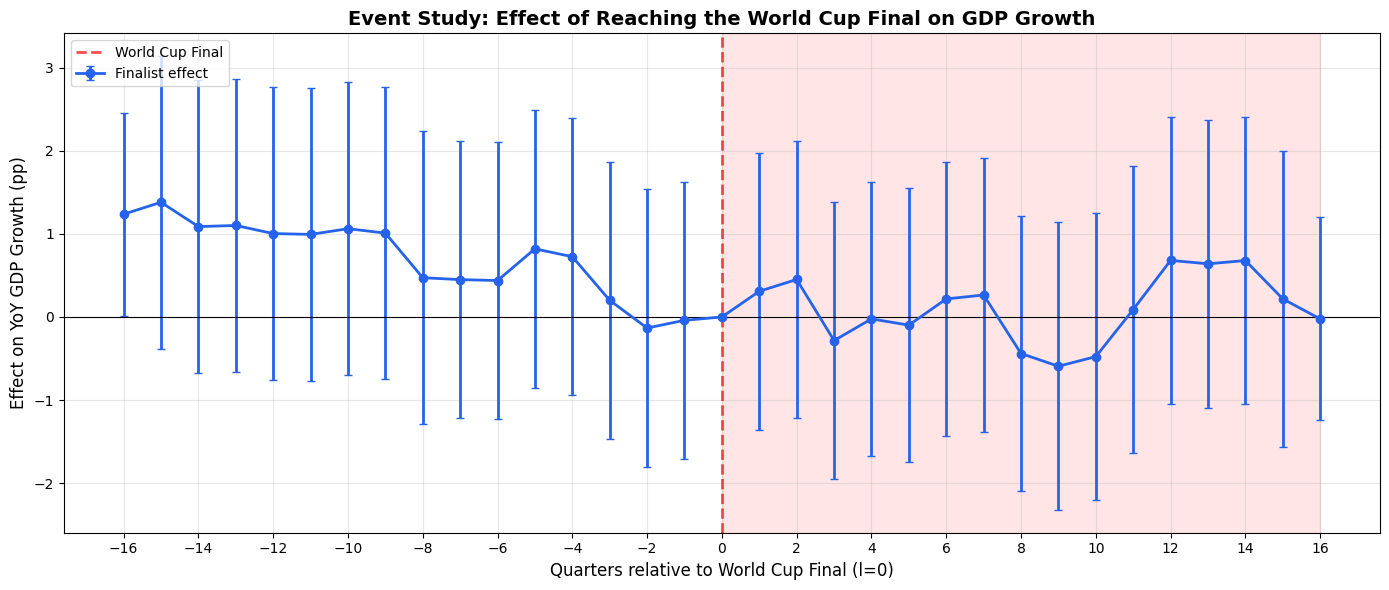

Saved: finalist_event_study.png


In [9]:
# Plot event study coefficients
fig, ax = plt.subplots(figsize=(14, 6))

plot_df = coef_df.sort_values('l')
l_vals = plot_df['l'].values
coefs = plot_df['coef'].values
ses = plot_df['se'].values

# Plot coefficients with 95% CI
ax.errorbar(l_vals, coefs, yerr=1.96*ses, fmt='o-', capsize=3, capthick=1,
            color='#2563eb', markersize=6, linewidth=2, label='Finalist effect')

# Reference lines
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='World Cup Final')

# Shade post-treatment
ax.axvspan(0, 16, alpha=0.1, color='red')

ax.set_xlabel('Quarters relative to World Cup Final (l=0)', fontsize=12)
ax.set_ylabel('Effect on YoY GDP Growth (pp)', fontsize=12)
ax.set_title('Event Study: Effect of Reaching the World Cup Final on GDP Growth', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 2))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('finalist_event_study.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: finalist_event_study.png")

---
# PART B: SYNTHETIC DIFFERENCE-IN-DIFFERENCES (SDID)
---

## 6. Create Stacked Panel for SDID

In [10]:
# SDID setup: use WC years 1998-2018 (like the paper)
wc_years_sdid = [1998, 2002, 2006, 2010, 2014, 2018]

# Finalists for each WC year
finalists_by_year = {
    1998: ['FRA', 'BRA'],
    2002: ['BRA', 'DEU'],
    2006: ['ITA', 'FRA'],
    2010: ['ESP', 'NLD'],
    2014: ['DEU', 'ARG'],
    2018: ['FRA', 'HRV'],
}

# Create flat list of (country, year) tuples for finalists
finalist_tuples = []
for yr, countries in finalists_by_year.items():
    for c in countries:
        finalist_tuples.append((c, yr))

print(f"Finalist events for SDID: {len(finalist_tuples)}")
for f in finalist_tuples:
    print(f"  {f[0]} - {f[1]}")

Finalist events for SDID: 12
  FRA - 1998
  BRA - 1998
  BRA - 2002
  DEU - 2002
  ITA - 2006
  FRA - 2006
  ESP - 2010
  NLD - 2010
  DEU - 2014
  ARG - 2014
  FRA - 2018
  HRV - 2018


In [11]:
# Outcome column for SDID
y_col_sdid = gdp_yoy_col  # YoY GDP growth in percentage points

# Create tq_num for stacking
df['tq_num'] = 4 * df['year'] + (df['qtr'] - 1)

# Event quarters
events_sdid = pd.DataFrame({
    'wc_year': wc_years_sdid,
    'event_tq': [4 * y + 1 for y in wc_years_sdid]  # Q2
})

# Create stacked panel: each country × WC year combination
# Window: rel_time in [-7, +2] (10 quarters, like the paper)
sdid_rows = []
for _, row in events_sdid.iterrows():
    wc_year = row['wc_year']
    event_tq = row['event_tq']
    
    temp = df[['country', 'year', 'qtr', 'tq_num', 'host', y_col_sdid]].copy()
    temp['wc_year'] = wc_year
    temp['rel_time'] = temp['tq_num'] - event_tq
    temp['unit_id'] = temp['country'] + '_' + str(wc_year)
    
    # Filter to window [-7, +2]
    temp = temp[(temp['rel_time'] >= -7) & (temp['rel_time'] <= 2)]
    sdid_rows.append(temp)

sdid_df = pd.concat(sdid_rows, ignore_index=True)
sdid_df = sdid_df.rename(columns={y_col_sdid: 'dy_gdp_pp'})

print(f"Stacked panel: {len(sdid_df):,} rows, {sdid_df['unit_id'].nunique()} unit-WC combinations")

Stacked panel: 2,824 rows, 284 unit-WC combinations


In [12]:
# Define treatment: finalist in their WC year
sdid_df['treated'] = sdid_df.apply(
    lambda r: 1 if (r['country'], r['wc_year']) in finalist_tuples else 0, axis=1
)

# Drop host-only subseries from donor pool (keep host+finalist like FRA-1998)
sdid_df['host_subseries'] = sdid_df.groupby('unit_id')['host'].transform('max')
sdid_df = sdid_df[~((sdid_df['host_subseries'] == 1) & (sdid_df['treated'] == 0))]

# Treatment indicator: D = 1 for treated units in post period (rel_time >= 1)
sdid_df['post'] = (sdid_df['rel_time'] >= 1).astype(int)
sdid_df['D'] = sdid_df['treated'] * sdid_df['post']

print(f"After dropping host-only: {sdid_df['unit_id'].nunique()} units")
print(f"Treated units (finalists): {sdid_df[sdid_df['treated']==1]['unit_id'].nunique()}")
print(f"Control units: {sdid_df[sdid_df['treated']==0]['unit_id'].nunique()}")

# List treated units
treated_list = sdid_df[sdid_df['treated']==1]['unit_id'].unique()
print("\nTreated units (finalists):")
for t in sorted(treated_list):
    print(f"  {t}")

After dropping host-only: 278 units
Treated units (finalists): 12
Control units: 266

Treated units (finalists):
  ARG_2014
  BRA_1998
  BRA_2002
  DEU_2002
  DEU_2014
  ESP_2010
  FRA_1998
  FRA_2006
  FRA_2018
  HRV_2018
  ITA_2006
  NLD_2010


## 7. Balance Panel and Build Matrices

In [13]:
# Require balanced 10-quarter panel with no missing outcomes
def is_balanced(g):
    return (g['rel_time'].nunique() == 10) and (g['dy_gdp_pp'].notna().all())

balanced_units = sdid_df.groupby('unit_id').filter(is_balanced)['unit_id'].unique()
sdid_df = sdid_df[sdid_df['unit_id'].isin(balanced_units)].copy()
sdid_df = sdid_df.sort_values(['unit_id', 'rel_time'])

print(f"Balanced panel: {sdid_df['unit_id'].nunique()} units × 10 quarters = {len(sdid_df)} rows")
print(f"Treated (finalists): {sdid_df[sdid_df['treated']==1]['unit_id'].nunique()} units")
print(f"Control: {sdid_df[sdid_df['treated']==0]['unit_id'].nunique()} units")

Balanced panel: 273 units × 10 quarters = 2730 rows
Treated (finalists): 11 units
Control: 262 units


In [14]:
# Build outcome matrix Y
Y_wide = sdid_df.pivot(index='unit_id', columns='rel_time', values='dy_gdp_pp')
Y_wide = Y_wide.sort_index()

# Treatment status per unit
treat_status = sdid_df.groupby('unit_id')['treated'].first()
treat_status = treat_status.loc[Y_wide.index]

# Separate treated and control
treated_units = treat_status[treat_status == 1].index.tolist()
control_units = treat_status[treat_status == 0].index.tolist()

# Reorder: controls first, then treated
unit_order = control_units + treated_units
Y = Y_wide.loc[unit_order].values

# Dimensions
N = len(unit_order)      # Total units
N0 = len(control_units)  # Control units
N1 = len(treated_units)  # Treated units
T = Y.shape[1]           # Total time periods
T0 = 8                   # Pre-treatment periods (q = -7 to 0)
T1 = 2                   # Post-treatment periods (q = 1, 2)

print(f"Y matrix: {N} units × {T} periods")
print(f"Controls (N0): {N0}, Treated (N1): {N1}")
print(f"Pre-periods (T0): {T0}, Post-periods (T1): {T1}")
print(f"Treated units: {treated_units}")

Y matrix: 273 units × 10 periods
Controls (N0): 262, Treated (N1): 11
Pre-periods (T0): 8, Post-periods (T1): 2
Treated units: ['ARG_2014', 'BRA_2002', 'DEU_2002', 'DEU_2014', 'ESP_2010', 'FRA_1998', 'FRA_2006', 'FRA_2018', 'HRV_2018', 'ITA_2006', 'NLD_2010']


## 8. SDID Estimator

In [15]:
def sdid_estimate(Y, N0, T0, regularization=1e-6):
    """
    Estimate SDiD ATT.
    
    Y: (N x T) outcome matrix, controls in rows [0:N0], treated in rows [N0:N]
    N0: number of control units
    T0: number of pre-treatment periods
    """
    N, T = Y.shape
    N1 = N - N0
    T1 = T - T0
    
    Y_co_pre = Y[:N0, :T0]   # Controls, pre-period
    Y_co_post = Y[:N0, T0:]  # Controls, post-period
    Y_tr_pre = Y[N0:, :T0]   # Treated, pre-period
    Y_tr_post = Y[N0:, T0:]  # Treated, post-period
    
    # Average treated outcomes
    Y_tr_pre_mean = Y_tr_pre.mean(axis=0)   # (T0,)
    Y_tr_post_mean = Y_tr_post.mean(axis=0) # (T1,)
    
    # Step 1: Compute unit weights (omega)
    def omega_objective(omega):
        synth_pre = omega @ Y_co_pre
        return np.sum((synth_pre - Y_tr_pre_mean)**2) + regularization * np.sum(omega**2)
    
    omega_init = np.ones(N0) / N0
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, None) for _ in range(N0)]
    
    res_omega = minimize(omega_objective, omega_init, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
    omega = res_omega.x
    
    # Step 2: Time weights (uniform for simplicity)
    lambda_weights = np.ones(T0) / T0
    
    # Step 3: Compute SDiD estimator
    Y_synth_post = omega @ Y_co_post
    Y_synth_pre = omega @ Y_co_pre
    
    pre_diff = Y_tr_pre_mean - Y_synth_pre
    did_adjustment = lambda_weights @ pre_diff
    
    post_diff = Y_tr_post_mean - Y_synth_post
    tau_hat = post_diff.mean() - did_adjustment
    
    return tau_hat, omega, lambda_weights

# Estimate SDID for finalists
tau_finalist, omega_finalist, lambda_finalist = sdid_estimate(Y, N0, T0)

print(f"\n{'='*60}")
print(f"SYNTHETIC DIFFERENCE-IN-DIFFERENCES: FINALIST ANALYSIS")
print(f"{'='*60}")
print(f"\nATT (effect of reaching WC Final on GDP growth): {tau_finalist:.4f} pp")


SYNTHETIC DIFFERENCE-IN-DIFFERENCES: FINALIST ANALYSIS

ATT (effect of reaching WC Final on GDP growth): 0.2046 pp


In [16]:
def bootstrap_se(Y, N0, T0, n_boot=500, seed=42):
    """Bootstrap standard error by resampling control units."""
    np.random.seed(seed)
    N, T = Y.shape
    boot_estimates = []
    
    for _ in range(n_boot):
        boot_idx = np.random.choice(N0, size=N0, replace=True)
        Y_boot = np.vstack([Y[boot_idx], Y[N0:]])
        
        try:
            tau_boot, _, _ = sdid_estimate(Y_boot, N0, T0)
            boot_estimates.append(tau_boot)
        except:
            pass
    
    return np.std(boot_estimates)

print("Computing bootstrap standard errors (500 replications)...")
se_finalist = bootstrap_se(Y, N0, T0, n_boot=500)

# Inference
z_stat = tau_finalist / se_finalist
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"\n{'='*60}")
print(f"SDID RESULTS: FINALIST ANALYSIS")
print(f"{'='*60}")
print(f"ATT:        {tau_finalist:.4f} pp")
print(f"SE:         {se_finalist:.4f}")
print(f"95% CI:     [{tau_finalist - 1.96*se_finalist:.4f}, {tau_finalist + 1.96*se_finalist:.4f}]")
print(f"z-stat:     {z_stat:.3f}")
print(f"p-value:    {p_value:.4f}")

# Store finalist SDID results
finalist_sdid_results = {
    'ATT': tau_finalist,
    'SE': se_finalist,
    'CI_lower': tau_finalist - 1.96*se_finalist,
    'CI_upper': tau_finalist + 1.96*se_finalist,
    'z_stat': z_stat,
    'p_value': p_value,
    'N_treated': N1,
    'N_control': N0
}

Computing bootstrap standard errors (500 replications)...



SDID RESULTS: FINALIST ANALYSIS
ATT:        0.2046 pp
SE:         0.3076
95% CI:     [-0.3983, 0.8075]
z-stat:     0.665
p-value:    0.5060


## 10. SDID Visualization

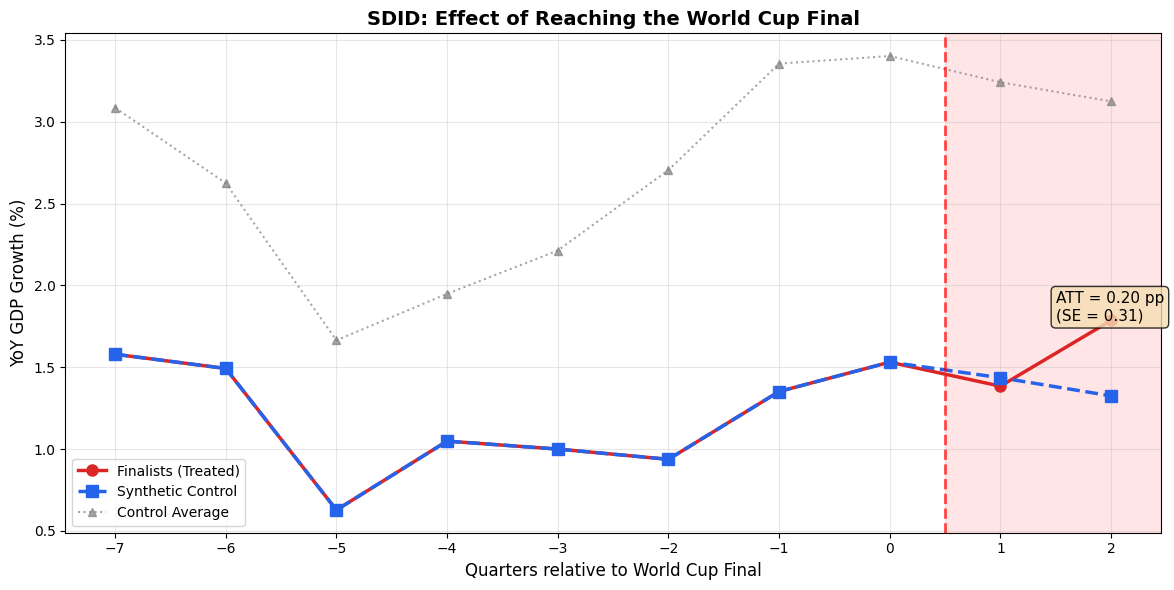

Saved: finalist_sdid.png


In [17]:
# Create SDID plot
time_periods = list(range(-7, 3))

# Average outcomes
Y_tr_avg = Y[N0:].mean(axis=0)
Y_co_avg = Y[:N0].mean(axis=0)
Y_synth = omega_finalist @ Y[:N0]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(time_periods, Y_tr_avg, 'o-', color='#dc2626', linewidth=2.5, markersize=8, label='Finalists (Treated)')
ax.plot(time_periods, Y_synth, 's--', color='#2563eb', linewidth=2.5, markersize=8, label='Synthetic Control')
ax.plot(time_periods, Y_co_avg, '^:', color='gray', linewidth=1.5, markersize=6, alpha=0.7, label='Control Average')

# Treatment line
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axvspan(0.5, 2.5, alpha=0.1, color='red')

# Annotate ATT
ax.annotate(f'ATT = {tau_finalist:.2f} pp\n(SE = {se_finalist:.2f})', 
            xy=(1.5, Y_tr_avg[-1]), fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlabel('Quarters relative to World Cup Final', fontsize=12)
ax.set_ylabel('YoY GDP Growth (%)', fontsize=12)
ax.set_title('SDID: Effect of Reaching the World Cup Final', fontsize=14, fontweight='bold')
ax.set_xticks(time_periods)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('finalist_sdid.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: finalist_sdid.png")

---
# PART C: COMPARISON WITH WINNER-ONLY ANALYSIS
---

## 11. Run Winner-Only SDID (for comparison)

In [18]:
# Winner-only analysis (replicating original)
winner_tuples = [
    ('FRA', 1998), ('BRA', 2002), ('ITA', 2006),
    ('ESP', 2010), ('DEU', 2014), ('FRA', 2018)
]

# Rebuild stacked panel for winner-only
sdid_rows_w = []
for _, row in events_sdid.iterrows():
    wc_year = row['wc_year']
    event_tq = row['event_tq']
    
    temp = df[['country', 'year', 'qtr', 'tq_num', 'host', y_col_sdid]].copy()
    temp['wc_year'] = wc_year
    temp['rel_time'] = temp['tq_num'] - event_tq
    temp['unit_id'] = temp['country'] + '_' + str(wc_year)
    temp = temp[(temp['rel_time'] >= -7) & (temp['rel_time'] <= 2)]
    sdid_rows_w.append(temp)

sdid_df_w = pd.concat(sdid_rows_w, ignore_index=True)
sdid_df_w = sdid_df_w.rename(columns={y_col_sdid: 'dy_gdp_pp'})

# Treatment: winner only
sdid_df_w['treated'] = sdid_df_w.apply(
    lambda r: 1 if (r['country'], r['wc_year']) in winner_tuples else 0, axis=1
)

# Drop host-only
sdid_df_w['host_subseries'] = sdid_df_w.groupby('unit_id')['host'].transform('max')
sdid_df_w = sdid_df_w[~((sdid_df_w['host_subseries'] == 1) & (sdid_df_w['treated'] == 0))]

# Balance panel
balanced_w = sdid_df_w.groupby('unit_id').filter(is_balanced)['unit_id'].unique()
sdid_df_w = sdid_df_w[sdid_df_w['unit_id'].isin(balanced_w)].copy()
sdid_df_w = sdid_df_w.sort_values(['unit_id', 'rel_time'])

# Build matrix
Y_wide_w = sdid_df_w.pivot(index='unit_id', columns='rel_time', values='dy_gdp_pp')
treat_status_w = sdid_df_w.groupby('unit_id')['treated'].first().loc[Y_wide_w.index]
treated_w = treat_status_w[treat_status_w == 1].index.tolist()
control_w = treat_status_w[treat_status_w == 0].index.tolist()
unit_order_w = control_w + treated_w
Y_w = Y_wide_w.loc[unit_order_w].values

N0_w = len(control_w)
N1_w = len(treated_w)

print(f"Winner-only panel: {len(unit_order_w)} units ({N1_w} treated, {N0_w} control)")
print(f"Treated units: {treated_w}")

Winner-only panel: 273 units (6 treated, 267 control)
Treated units: ['BRA_2002', 'DEU_2014', 'ESP_2010', 'FRA_1998', 'FRA_2018', 'ITA_2006']


In [19]:
# Estimate winner-only SDID
tau_winner, omega_winner, _ = sdid_estimate(Y_w, N0_w, T0)

print("Computing bootstrap SE for winner-only...")
se_winner = bootstrap_se(Y_w, N0_w, T0, n_boot=500)

z_winner = tau_winner / se_winner
p_winner = 2 * (1 - stats.norm.cdf(abs(z_winner)))

print(f"\n{'='*60}")
print(f"SDID RESULTS: WINNER-ONLY ANALYSIS")
print(f"{'='*60}")
print(f"ATT:        {tau_winner:.4f} pp")
print(f"SE:         {se_winner:.4f}")
print(f"95% CI:     [{tau_winner - 1.96*se_winner:.4f}, {tau_winner + 1.96*se_winner:.4f}]")
print(f"z-stat:     {z_winner:.3f}")
print(f"p-value:    {p_winner:.4f}")

Computing bootstrap SE for winner-only...



SDID RESULTS: WINNER-ONLY ANALYSIS
ATT:        0.4314 pp
SE:         0.2802
95% CI:     [-0.1178, 0.9806]
z-stat:     1.539
p-value:    0.1237


## 12. Comparison Summary

In [20]:
# Create comparison table
comparison = pd.DataFrame({
    'Treatment': ['Winner Only', 'Finalist (Winner + Runner-up)'],
    'N Treated': [N1_w, N1],
    'N Control': [N0_w, N0],
    'ATT (pp)': [tau_winner, tau_finalist],
    'SE': [se_winner, se_finalist],
    'CI Lower': [tau_winner - 1.96*se_winner, tau_finalist - 1.96*se_finalist],
    'CI Upper': [tau_winner + 1.96*se_winner, tau_finalist + 1.96*se_finalist],
    'z-stat': [z_winner, z_stat],
    'p-value': [p_winner, p_value]
})

print("\n" + "="*80)
print("COMPARISON: WINNER vs FINALIST TREATMENT")
print("="*80)
print(comparison.to_string(index=False))


COMPARISON: WINNER vs FINALIST TREATMENT
                    Treatment  N Treated  N Control  ATT (pp)     SE  CI Lower  CI Upper  z-stat  p-value
                  Winner Only          6        267    0.4314 0.2802   -0.1178    0.9806  1.5394   0.1237
Finalist (Winner + Runner-up)         11        262    0.2046 0.3076   -0.3983    0.8075  0.6651   0.5060


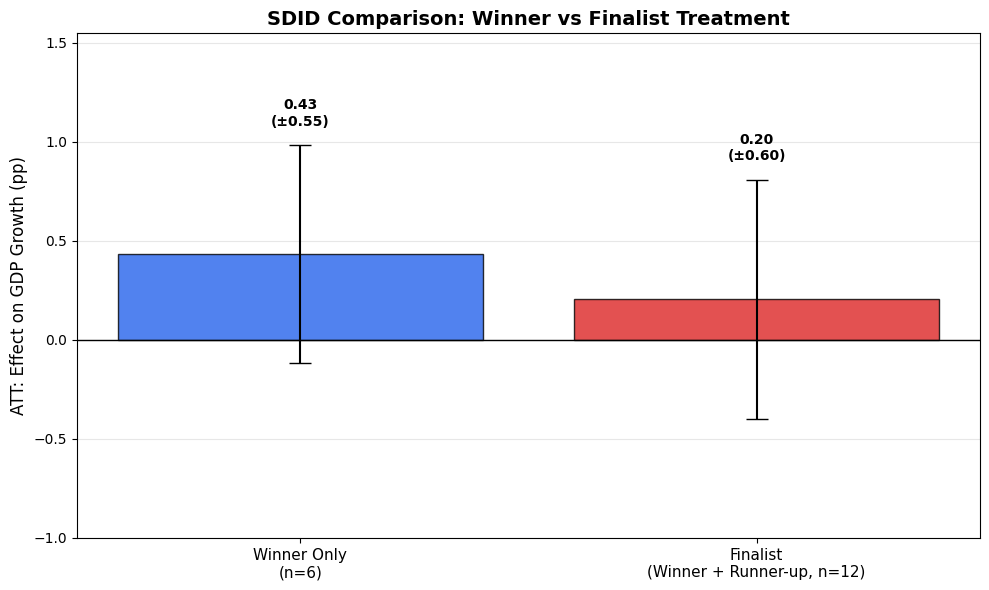

Saved: finalist_vs_winner_comparison.png


In [21]:
# Visualization: Compare ATT estimates
fig, ax = plt.subplots(figsize=(10, 6))

treatments = ['Winner Only\n(n=6)', 'Finalist\n(Winner + Runner-up, n=12)']
atts = [tau_winner, tau_finalist]
ses = [se_winner, se_finalist]
colors = ['#2563eb', '#dc2626']

x = np.arange(len(treatments))
bars = ax.bar(x, atts, yerr=[1.96*s for s in ses], capsize=8, color=colors, alpha=0.8, edgecolor='black')

ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('ATT: Effect on GDP Growth (pp)', fontsize=12)
ax.set_title('SDID Comparison: Winner vs Finalist Treatment', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(treatments, fontsize=11)

# Add value labels
for i, (att, se) in enumerate(zip(atts, ses)):
    ax.annotate(f'{att:.2f}\n(±{1.96*se:.2f})', xy=(i, att + 1.96*se + 0.1), 
                ha='center', fontsize=10, fontweight='bold')

ax.set_ylim(-1, max(atts) + 2*max(ses) + 0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('finalist_vs_winner_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: finalist_vs_winner_comparison.png")

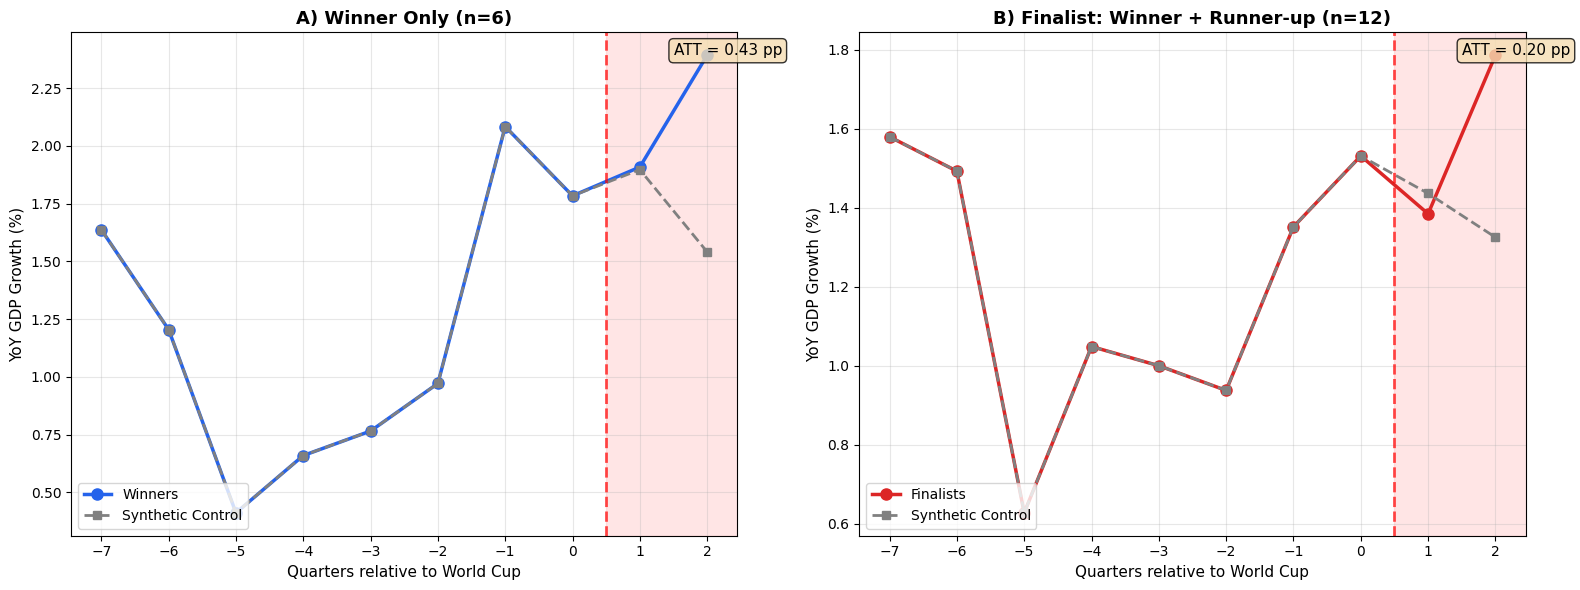

Saved: finalist_sdid_comparison_panels.png


In [22]:
# Combined SDID trajectories plot
time_periods = list(range(-7, 3))

# Finalist trajectories
Y_tr_finalist = Y[N0:].mean(axis=0)
Y_synth_finalist = omega_finalist @ Y[:N0]

# Winner trajectories
Y_tr_winner = Y_w[N0_w:].mean(axis=0)
Y_synth_winner = omega_winner @ Y_w[:N0_w]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Winner only
ax = axes[0]
ax.plot(time_periods, Y_tr_winner, 'o-', color='#2563eb', linewidth=2.5, markersize=8, label='Winners')
ax.plot(time_periods, Y_synth_winner, 's--', color='gray', linewidth=2, markersize=6, label='Synthetic Control')
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axvspan(0.5, 2.5, alpha=0.1, color='red')
ax.annotate(f'ATT = {tau_winner:.2f} pp', xy=(1.5, Y_tr_winner[-1]), fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax.set_xlabel('Quarters relative to World Cup', fontsize=11)
ax.set_ylabel('YoY GDP Growth (%)', fontsize=11)
ax.set_title('A) Winner Only (n=6)', fontsize=13, fontweight='bold')
ax.set_xticks(time_periods)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

# Panel B: Finalist
ax = axes[1]
ax.plot(time_periods, Y_tr_finalist, 'o-', color='#dc2626', linewidth=2.5, markersize=8, label='Finalists')
ax.plot(time_periods, Y_synth_finalist, 's--', color='gray', linewidth=2, markersize=6, label='Synthetic Control')
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axvspan(0.5, 2.5, alpha=0.1, color='red')
ax.annotate(f'ATT = {tau_finalist:.2f} pp', xy=(1.5, Y_tr_finalist[-1]), fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax.set_xlabel('Quarters relative to World Cup', fontsize=11)
ax.set_ylabel('YoY GDP Growth (%)', fontsize=11)
ax.set_title('B) Finalist: Winner + Runner-up (n=12)', fontsize=13, fontweight='bold')
ax.set_xticks(time_periods)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('finalist_sdid_comparison_panels.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: finalist_sdid_comparison_panels.png")

## 13. Final Summary

In [23]:
# Final summary output
print("\n" + "="*80)
print("FINAL SUMMARY: FINALIST ANALYSIS")
print("="*80)
print(f"""
RESEARCH QUESTION:
Does reaching the World Cup Final (not just winning) affect GDP growth?

TREATMENT DEFINITIONS:
- Winner Only: Countries that WON the World Cup (n=6 events in 1998-2018)
- Finalist: Countries that reached the FINAL (won OR lost, n=12 events in 1998-2018)

NEW COUNTRIES INCLUDED (Runner-up only):
{runner_up_only}

SDID RESULTS COMPARISON:
┌────────────────────────────────┬───────────┬──────────┬─────────────────────────┬─────────┐
│ Treatment                      │ ATT (pp)  │ SE       │ 95% CI                  │ p-value │
├────────────────────────────────┼───────────┼──────────┼─────────────────────────┼─────────┤
│ Winner Only                    │ {tau_winner:>8.4f}  │ {se_winner:>7.4f}  │ [{tau_winner-1.96*se_winner:>7.3f}, {tau_winner+1.96*se_winner:>7.3f}]  │ {p_winner:>6.4f}  │
│ Finalist (Winner + Runner-up) │ {tau_finalist:>8.4f}  │ {se_finalist:>7.4f}  │ [{tau_finalist-1.96*se_finalist:>7.3f}, {tau_finalist+1.96*se_finalist:>7.3f}]  │ {p_value:>6.4f}  │
└────────────────────────────────┴───────────┴──────────┴─────────────────────────┴─────────┘

INTERPRETATION:
- ATT > 0 suggests positive effect on GDP growth
- Compare magnitude and significance between treatments
- Wider treatment definition (finalist) may dilute or strengthen the effect
""")

# Save results to CSV
comparison.to_csv('results/finalist_analysis_results.csv', index=False)
print("Results saved to: finalist_analysis_results.csv")


FINAL SUMMARY: FINALIST ANALYSIS

RESEARCH QUESTION:
Does reaching the World Cup Final (not just winning) affect GDP growth?

TREATMENT DEFINITIONS:
- Winner Only: Countries that WON the World Cup (n=6 events in 1998-2018)
- Finalist: Countries that reached the FINAL (won OR lost, n=12 events in 1998-2018)

NEW COUNTRIES INCLUDED (Runner-up only):
['NLD', 'ARG', 'HRV']

SDID RESULTS COMPARISON:
┌────────────────────────────────┬───────────┬──────────┬─────────────────────────┬─────────┐
│ Treatment                      │ ATT (pp)  │ SE       │ 95% CI                  │ p-value │
├────────────────────────────────┼───────────┼──────────┼─────────────────────────┼─────────┤
│ Winner Only                    │   0.4314  │  0.2802  │ [ -0.118,   0.981]  │ 0.1237  │
│ Finalist (Winner + Runner-up) │   0.2046  │  0.3076  │ [ -0.398,   0.808]  │ 0.5060  │
└────────────────────────────────┴───────────┴──────────┴─────────────────────────┴─────────┘

INTERPRETATION:
- ATT > 0 suggests positive e